In [1]:
import os
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from mrcnn import visualize
import mrcnn.model as modellib

import bread

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_PATH = os.path.join(ROOT_DIR, "models/bread_ver_5.h5")
DATASET_DIR = os.path.join(os.getcwd(), 'data')

DEVICE = "/gpu:0"
TEST_MODE = "inference"

config = bread.BreadInferenceConfig()
print(config.RPN_NMS_THRESHOLD)
config.DETECTION_MIN_CONFIDENCE = 0.7
print(config.DETECTION_MIN_CONFIDENCE)

0.8
0.7


Using TensorFlow backend.


In [12]:
dataset = bread.BreadDataset()
dataset.load_bread(DATASET_DIR, subset='val')
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 51
Class Count: 7
  0. BG                                                
  1. red-bean-bread                                    
  2. soblo                                             
  3. cream-bread                                       
  4. pizza-bread                                       
  5. tart                                              
  6. walnut-pie                                        


In [3]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Load weights
print("Loading weights ", MODEL_PATH)
model.load_weights(MODEL_PATH, by_name=True)

Loading weights  /notebooks/works/models/bread_ver_5.h5


In [9]:
# Calculate accuracy of object detection:
# 1. Change list to dictionary that containing product name and product count 
#    {'product_A': counts, 'product_B': counts, ...}
# 2. Compare ground truth dictionary with predict dictionary, 
#    and calculate the sum of the absolute value of the difference.
# 3. Return difference and total counts of ground truth items
def cal_accuracy(gt_list, pre_list):
    # 1. Change list to dict
    gt_dict = Counter(gt_list)
    pre_dict = Counter(pre_list)
    # 2. Compare gt dict with predict dict
    gt_dict.subtract(pre_dict)
    diff = [abs(x) for x in gt_dict.values() if x > 0]
#     diff = [abs(x) for x in gt_dict.values()]
    # 3. Retrun sum of difference and total counts of gt_items
    return sum(diff), len(gt_list)

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Error: 328.jpg 
mis_counts: 1 
Gt_class: [6 6 6 2 2 5 5 5 4 4] 
Pre_class: [2 4 2 6 6 4 5 5 6 3] 

=== results ===
mis_counts:     1,  total_counts:   185,  accuracy:  0.99459


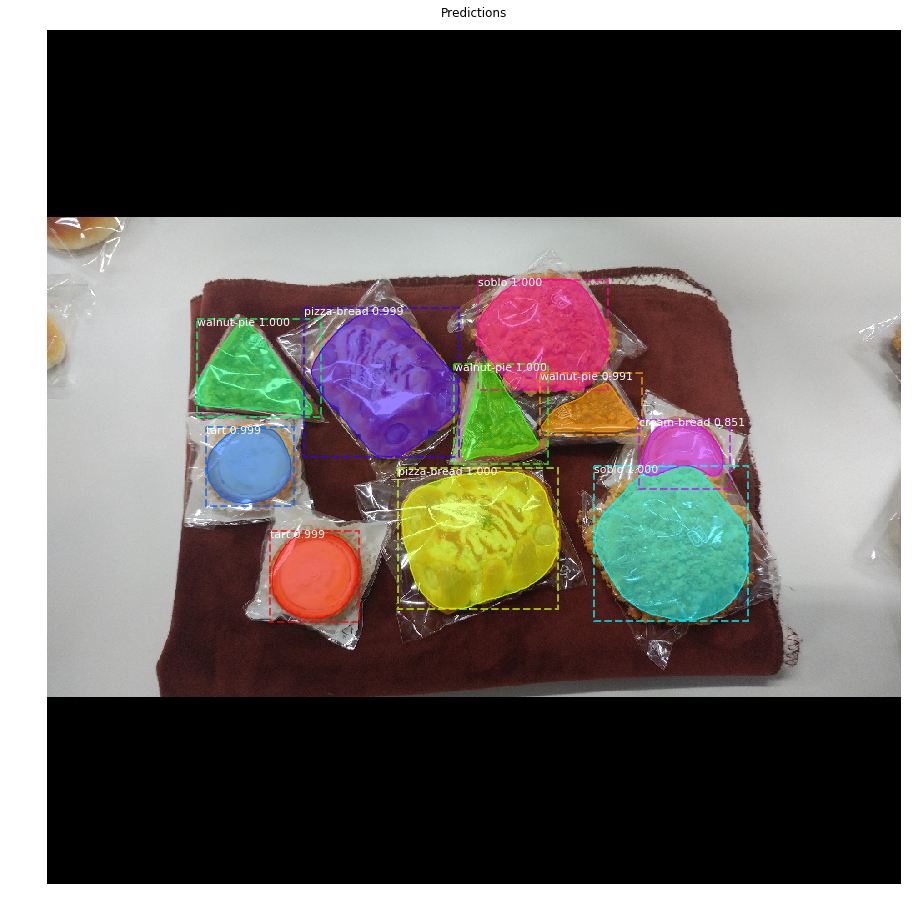

In [13]:
def get_image_name(count):
    return dataset.source_image_link(count).split('/')[-1]

mis_counts, total_counts = 0, 0

for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    pre_class_id = results[0]['class_ids']
    # Calculate accuracy
    mis, total = cal_accuracy(gt_class_id, pre_class_id)
    mis_counts += mis
    total_counts += total
    if(mis > 0):
        print('Error:', get_image_name(image_id), '\nmis_counts:', mis,
              '\nGt_class:', gt_class_id, '\nPre_class:', pre_class_id, '\n')
        
        ax = get_ax(1)
        r = results[0]
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
        
print('=== results ===')
text = "mis_counts: {:5},  total_counts: {:5},  accuracy: {:8.5f}".format(\
        mis_counts, total_counts, (total_counts-mis_counts)/total_counts)
print(text)